In [2]:
# Imports for the Modeling Function
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from numpy import concatenate
from numpy import sqrt 
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error as mae
import datetime
from dateutil.relativedelta import *
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [3]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

numpy==1.19.2
pandas==1.2.4


In [4]:
# convert series to supervised learning
# Need this defiinition as well
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [5]:
def Predict_Future(data, length):
    # fix random seed for reproducibility
    numpy.random.seed(7)
    pd.set_option('display.max_columns', None)
    
    # Read in Dataset, and Remove Repeated Variables
    # Make sure to upload data frame with at least 12 rows of empty that are past the current date. 
    dataset=pd.read_csv(data, index_col='DATE')
    
    # Setting up data for a 3 month prediction
    if length == 3:
        df = dataset.head(-33)
        df.index = pd.to_datetime(df.index)
        # Grabe the Values of the Data
        values = df.values
        # integer encode direction
        encoder = LabelEncoder()
        values[:,4] = encoder.fit_transform(values[:,4])
        # ensure all data is float
        values = values.astype('float32')
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        
        # frame as supervised learning
        # specify the number of lag months
        n_months = 15 
        n_features = df.shape[1]
        # frame as supervised learning
        reframed = series_to_supervised(scaled, n_months, 1)
        
        # frame as supervised learning
        list_a = list(range(0,13*n_features))
        reframed_b = reframed.iloc[:, list_a]
        # get teh values and find the currect train and test split
        values = reframed_b.values
        n_train_hours = int(len(values) - length)
        title = '3 Month Future Prediction'
        
        # Setting up data for a 3 month prediction
    if length == 6:
        df = dataset.head(-30)
        df.index = pd.to_datetime(df.index)
        # Grabe the Values of the Data
        values = df.values
        # integer encode direction
        encoder = LabelEncoder()
        values[:,4] = encoder.fit_transform(values[:,4])
        # ensure all data is float
        values = values.astype('float32')
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        
        # frame as supervised learning
        # specify the number of lag months
        n_months = 18 
        n_features = df.shape[1]
        # frame as supervised learning
        reframed = series_to_supervised(scaled, n_months, 1)
        
        # frame as supervised learning
        list_a = list(range(0,13*n_features))
        reframed_b = reframed.iloc[:, list_a]
        #print(reframed_b)
        # get teh values and find the currect train and test split
        values = reframed_b.values
        n_train_hours = int(len(values) - length)
        title = '6 Month Future Prediction'
    
    # Set up dataframe for predicting one year into the Future 
    if length == 12:
        df = dataset.head(-24)
        df.index = pd.to_datetime(df.index)
        # Grabe the Values of the Data
        values = df.values
        # integer encode direction
        encoder = LabelEncoder()
        values[:,4] = encoder.fit_transform(values[:,4])
        # ensure all data is float
        values = values.astype('float32')
        # normalize features
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        
        # frame as supervised learning
        # specify the number of lag months
        n_months = 24 
        n_features = df.shape[1]
        # frame as supervised learning
        reframed = series_to_supervised(scaled, n_months, 1)
        
        # frame as supervised learning
        list_a = list(range(0,13*n_features))
        reframed_b = reframed.iloc[:, list_a]
        # get teh values and find the currect train and test split
        values = reframed_b.values
        n_train_hours = int(len(values) - length)
        title = 'One Year Future Prediction'
        
        
    # Begin the Modeling
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    
    
    # Predict the Future
    yhat = model.predict(test_X)
    # Get other predicted economic factors
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    ccol = n_features-1
    inv_yhat = concatenate((yhat, test_X[:, -ccol:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    # grab just Predicted Dry_van 
    inv_yhatdv = inv_yhat[:,0]
    print(inv_yhatdv)
    
    # Begin to create df to add the new prediction too
    df_test1 = df[df['DRY VANS'] == 0]
    # Add Prediction
    df_test1['Pred_DryVans'] = inv_yhatdv.tolist()
    # Create new dv to see just the dv and predicted
    df_fut = df_test1[['DRY VANS','Pred_DryVans']]
    
    # plot history
    pyplot.figure(figsize=(20, 10))
    pyplot.plot(df['DRY VANS'], label='Actual')
    pyplot.plot(df_fut['Pred_DryVans'], label='Predicted')
    plt.title(title)
    plt.gcf().autofmt_xdate()
    pyplot.legend()
    pyplot.show()
    
    return(df_fut)
            
    

    
    
    
    
    
    
    
    

In [10]:
da_frame = 'Mock_Data.csv'

Epoch 1/50
4/4 - 2s - loss: 0.2468 - val_loss: 0.1599
Epoch 2/50
4/4 - 0s - loss: 0.1709 - val_loss: 0.1671
Epoch 3/50
4/4 - 0s - loss: 0.1934 - val_loss: 0.1461
Epoch 4/50
4/4 - 0s - loss: 0.1712 - val_loss: 0.1351
Epoch 5/50
4/4 - 0s - loss: 0.1585 - val_loss: 0.1373
Epoch 6/50
4/4 - 0s - loss: 0.1714 - val_loss: 0.1340
Epoch 7/50
4/4 - 0s - loss: 0.1599 - val_loss: 0.1409
Epoch 8/50
4/4 - 0s - loss: 0.1555 - val_loss: 0.1357
Epoch 9/50
4/4 - 0s - loss: 0.1592 - val_loss: 0.1365
Epoch 10/50
4/4 - 0s - loss: 0.1558 - val_loss: 0.1400
Epoch 11/50
4/4 - 0s - loss: 0.1526 - val_loss: 0.1390
Epoch 12/50
4/4 - 0s - loss: 0.1543 - val_loss: 0.1407
Epoch 13/50
4/4 - 0s - loss: 0.1525 - val_loss: 0.1450
Epoch 14/50
4/4 - 0s - loss: 0.1481 - val_loss: 0.1439
Epoch 15/50
4/4 - 0s - loss: 0.1525 - val_loss: 0.1508
Epoch 16/50
4/4 - 0s - loss: 0.1483 - val_loss: 0.1452
Epoch 17/50
4/4 - 0s - loss: 0.1467 - val_loss: 0.1499
Epoch 18/50
4/4 - 0s - loss: 0.1445 - val_loss: 0.1458
Epoch 19/50
4/4 - 0

<ipython-input-5-bd0573101a20>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['Pred_DryVans'] = inv_yhatdv.tolist()


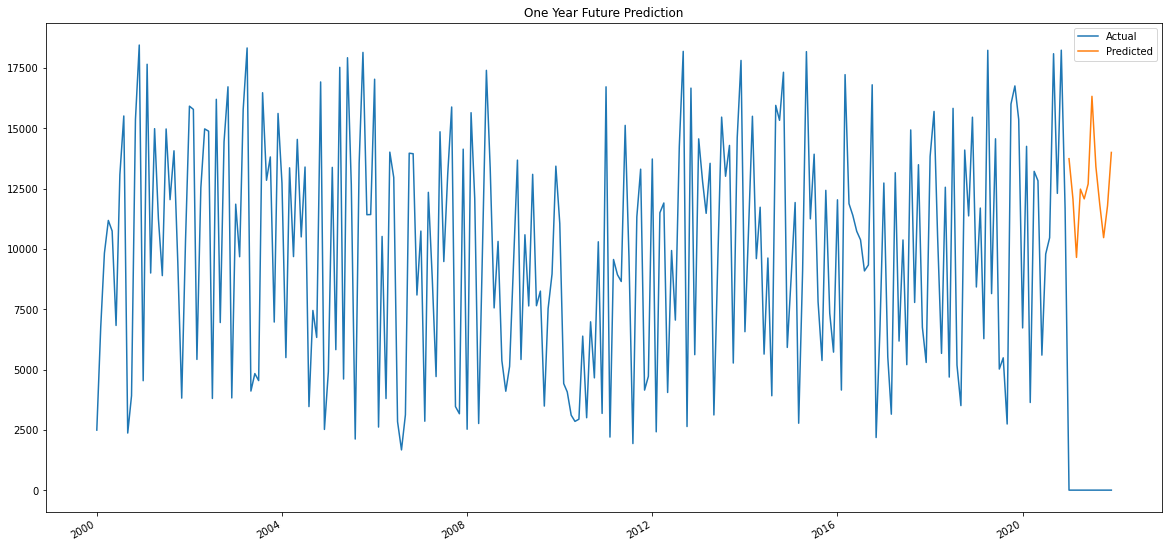

In [11]:
results1 = Predict_Future(da_frame, 12)

Epoch 1/50
4/4 - 0s - loss: 0.6386 - val_loss: 0.1487
Epoch 2/50
4/4 - 0s - loss: 0.2721 - val_loss: 0.1944
Epoch 3/50
4/4 - 0s - loss: 0.1243 - val_loss: 0.1359
Epoch 4/50
4/4 - 0s - loss: 0.1439 - val_loss: 0.1278
Epoch 5/50
4/4 - 0s - loss: 0.0988 - val_loss: 0.0339
Epoch 6/50
4/4 - 0s - loss: 0.0970 - val_loss: 0.0645
Epoch 7/50
4/4 - 0s - loss: 0.0672 - val_loss: 0.0382
Epoch 8/50
4/4 - 0s - loss: 0.0734 - val_loss: 0.0234
Epoch 9/50
4/4 - 0s - loss: 0.0667 - val_loss: 0.0304
Epoch 10/50
4/4 - 0s - loss: 0.0585 - val_loss: 0.0250
Epoch 11/50
4/4 - 0s - loss: 0.0607 - val_loss: 0.0218
Epoch 12/50
4/4 - 0s - loss: 0.0589 - val_loss: 0.0220
Epoch 13/50
4/4 - 0s - loss: 0.0581 - val_loss: 0.0276
Epoch 14/50
4/4 - 0s - loss: 0.0566 - val_loss: 0.0221
Epoch 15/50
4/4 - 0s - loss: 0.0535 - val_loss: 0.0256
Epoch 16/50
4/4 - 0s - loss: 0.0556 - val_loss: 0.0263
Epoch 17/50
4/4 - 0s - loss: 0.0527 - val_loss: 0.0218
Epoch 18/50
4/4 - 0s - loss: 0.0512 - val_loss: 0.0281
Epoch 19/50
4/4 - 0

<ipython-input-5-bd0573101a20>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['Pred_DryVans'] = inv_yhatdv.tolist()


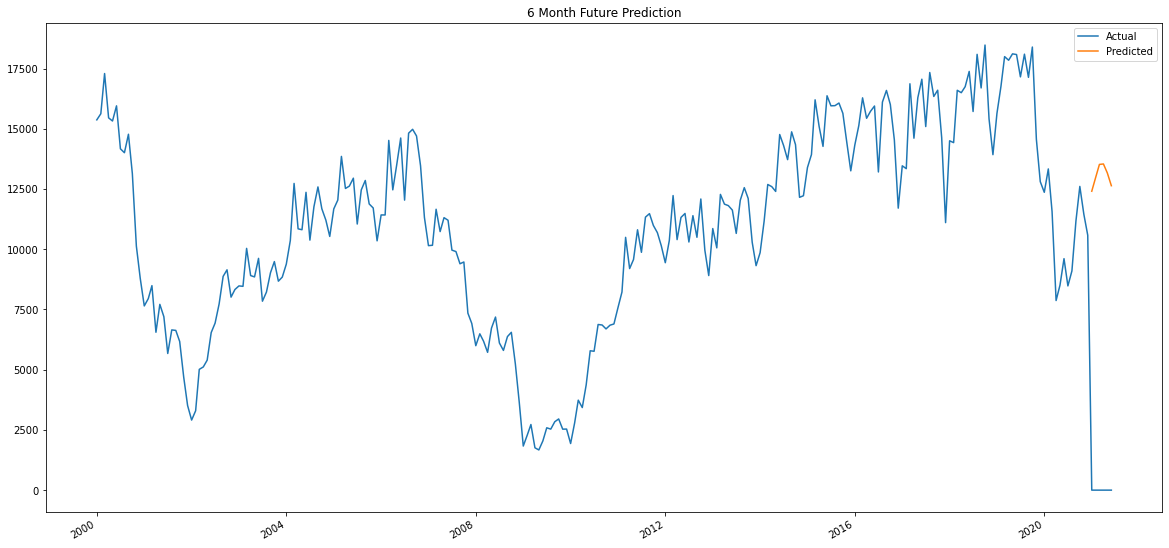

In [8]:
results6 = Predict_Future(da_frame, 6)

Epoch 1/50
4/4 - 1s - loss: 0.4586 - val_loss: 0.1476
Epoch 2/50
4/4 - 0s - loss: 0.1246 - val_loss: 0.0333
Epoch 3/50
4/4 - 0s - loss: 0.1125 - val_loss: 0.1157
Epoch 4/50
4/4 - 0s - loss: 0.1130 - val_loss: 0.0208
Epoch 5/50
4/4 - 0s - loss: 0.0988 - val_loss: 0.0963
Epoch 6/50
4/4 - 0s - loss: 0.0815 - val_loss: 0.0271
Epoch 7/50
4/4 - 0s - loss: 0.0817 - val_loss: 0.0334
Epoch 8/50
4/4 - 0s - loss: 0.0703 - val_loss: 0.0311
Epoch 9/50
4/4 - 0s - loss: 0.0662 - val_loss: 0.0125
Epoch 10/50
4/4 - 0s - loss: 0.0632 - val_loss: 0.0221
Epoch 11/50
4/4 - 0s - loss: 0.0625 - val_loss: 0.0154
Epoch 12/50
4/4 - 0s - loss: 0.0588 - val_loss: 0.0072
Epoch 13/50
4/4 - 0s - loss: 0.0588 - val_loss: 0.0160
Epoch 14/50
4/4 - 0s - loss: 0.0563 - val_loss: 0.0084
Epoch 15/50
4/4 - 0s - loss: 0.0530 - val_loss: 0.0103
Epoch 16/50
4/4 - 0s - loss: 0.0521 - val_loss: 0.0104
Epoch 17/50
4/4 - 0s - loss: 0.0505 - val_loss: 0.0119
Epoch 18/50
4/4 - 0s - loss: 0.0495 - val_loss: 0.0125
Epoch 19/50
4/4 - 0

<ipython-input-5-bd0573101a20>:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test1['Pred_DryVans'] = inv_yhatdv.tolist()


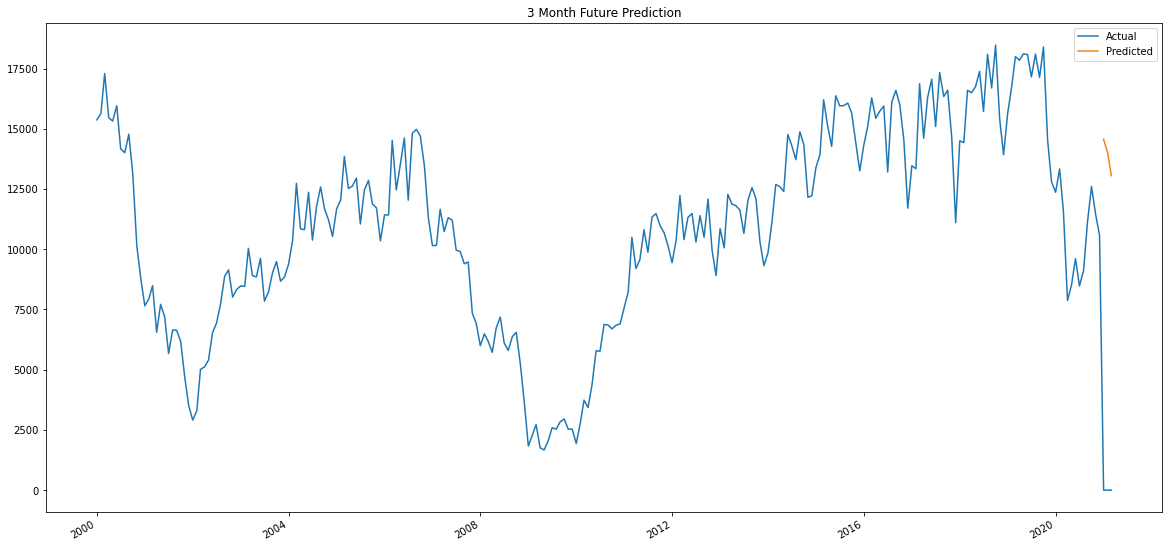

In [9]:
results3 = Predict_Future(da_frame, 3)